## mfDCA and Counts of Double Mutants

This notebook calculates the full Mean Field DCA (mfDCA) contacts and then looks at the relation to the number of unique double mutants at each pair of sites. 

[Dependencies on previous notebooks](./PCA_to_DCA.ipynb)

### Results
We are checking to see if contacts have lower unique pair counts (yes). Surprisingly, the mfDCA approach picks predictions with higher pair counts. Inspite of this mfDCA has high accuracy for its predictions. 

### Sections

1. [Load previously generated data](#dataload)
2. [Mean Field Approximation](#meanfield)  
3. [Contact Prediction](#contactprediction)
4. [Contact Map](#contactmap)
5. [Plot Unique Pair Counts](#uniquepaircounts)
6. [Distrubution of Unique Pair Counts](#paircountdist)
***


### Load previously generated data  <a id="dataload"></a>

We load in the previous [DHFR](https://www.uniprot.org/uniprot/P00374) calculations from its MSA. 

In [1]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
datadir = "../data"
msa_file = os.path.join(datadir, "DHFR.aln")

# Read all the lines in the file into a 2D array of type S1
with open(msa_file) as fh:
    arr = np.array([[x for x in line.strip()] for line in fh], np.dtype("S1"))

print("shape =", arr.shape, ",dtype= ", arr.dtype)

shape = (56165, 186) ,dtype=  |S1


In [3]:
# M is the number of sequences
# L is the length
M, L = arr.shape
print("Number of sequences : {} ".format(M))
print("Sequence Length : {}".format(L))

Number of sequences : 56165 
Sequence Length : 186


We can order the amino acids any way we like. Here is a sorting based on some amino acid properties. 
https://proteinstructures.com/Structure/Structure/amino-acids.html

In [4]:
AMINO_ACIDS = np.array([aa for aa in "RKDEQNHSTCYWAILMFVPG-"], "S1")

In [5]:
weights_file = os.path.join(datadir, "DHFR.weights.npy")
weights = np.load(weights_file)
print("Loading weights from : ", weights_file)

Loading weights from :  ../data/DHFR.weights.npy


In [6]:
# number of effective sequences
M_eff = sum(weights) # Eqn 28 in 2013Cocco
print(int(round(M_eff)))

15238


In [7]:
# q is the alphabet
q = len(AMINO_ACIDS)
pseudo_count = round(M_eff)

In [8]:
single_site_marginal_file = os.path.join(datadir, "DHFR.single.npy")
double_site_marginal_file = os.path.join(datadir, "DHFR.double.npy")
f_i_a = np.load(single_site_marginal_file)
print("Loading single site marginals from ", single_site_marginal_file)

f_i_j_a_b = np.load(double_site_marginal_file)
print("Loading double site marginals from ", double_site_marginal_file)    

Loading single site marginals from  ../data/DHFR.single.npy
Loading double site marginals from  ../data/DHFR.double.npy


In [9]:
# Add Pseudo count and compute the marginals (Eqn 29 and 30 2013Cocco)
pseudo_count_ratio = float(pseudo_count) / (M_eff + pseudo_count)
f_i_a = (pseudo_count_ratio / q ) + (1 - pseudo_count_ratio) * f_i_a / M_eff
f_i_j_a_b = (pseudo_count_ratio  / (q*q) ) + (1 - pseudo_count_ratio) * f_i_j_a_b / M_eff


# The formula for f_i_j_a_b is a little different when i==j
# essentially we have f_i_a on the diagonal and zero's everywhere else. 
for i in range(L):
    f_i_j_a_b[i, :, i, :] = np.diag(f_i_a[i, :])

In [10]:
# Covariance Matrix
# We take an outer product of f_i_a with itself using numpy's broadcasting rules. 
# This gives us a matrix where the (i,a, j, b) index is f[i,a] * f[j,b]
C_i_j_a_b = f_i_j_a_b  - f_i_a[:, :, np.newaxis, np.newaxis] * f_i_a[np.newaxis, np.newaxis, :, :] 

# we project the covariance matrix down the first q-1 elements
# Since the frequencies add up to 1 we can discard amino-acid value (a = q) for each site
# without losing any information
C_i_j_a_b = C_i_j_a_b[:, :(q-1), :, :(q-1)]
print("C_i_j_a_b.shape = {}".format(C_i_j_a_b.shape)) 

# delete the frequency matrices now that we have a covariance matrix.
del f_i_a, f_i_j_a_b

C_i_j_a_b.shape = (186, 20, 186, 20)


### Mean Field Approximation <a id="meanfield"></a>
This is an approximation in statistical physics to help solve this intractable problem. We expand the exponential of the sum of the direct couplings using a Taylor Series expansion and then only keep the linear terms. With this approximation the values for the direct couplings are $$e_{ij}(a,b) = (C^{-1})_{ij}(a,b) \qquad \forall i,j, \enspace \forall a,b=1, \ldots, q-1$$ and $$e_{ij}(a,q) = e_{ij}(q,a) = 0 \qquad \forall a = 1, \ldots, q,$$ and $$ h_i(q) = 0.$$

This approximation approach is known as **mean field direct coupling analysis (mfDCA)**. Once the direct couplings have been calculated, they can be used to predict contacts between residues. This post processing prediction step will be covered later. 

In [11]:
# Our Covariance matrix is now invertible
cov = C_i_j_a_b.reshape((L*(q-1), L*(q-1)))
# Getting the full couplings via the full inverse covariance matrix
invCov = np.linalg.inv(cov)
e_i_j_a_b = invCov.reshape((L, q-1, L, q-1))

### Contact Prediction <a id="contactprediction" />

In [12]:
# load in the contacts file
contacts_5A = np.array(np.load("{0:}/5A-HA-3k47_contacts.pkl".format(datadir)))
contacts_8A = np.array(np.load("{0:}/8A-HA-3k47_contacts.pkl".format(datadir))) 

# convert contacts to 0 based indices
contacts_5A -= 1
contacts_8A -= 1

# create a contacts array
contacts = np.zeros((L, L), dtype=np.int)
contacts[contacts_8A[:, 0], contacts_8A[:, 1]] = 8
contacts[contacts_8A[:, 1], contacts_8A[:, 0]] = 8
contacts[contacts_5A[:, 0], contacts_5A[:, 1]] = 5
contacts[contacts_5A[:, 1], contacts_5A[:, 0]] = 5

In [13]:
etilde_i_j_a_b = e_i_j_a_b - e_i_j_a_b.mean(axis=3, keepdims=True) - \
        e_i_j_a_b.mean(axis=1, keepdims=True) + \
        e_i_j_a_b.mean(axis=3, keepdims=True).mean(axis=1, keepdims=True)

etilde_i_j_a_b.shape

F_i_j = np.linalg.norm(etilde_i_j_a_b, ord="fro", axis=(1,3))

Fapc_i_j = F_i_j - F_i_j.mean(axis=0, keepdims=True) * F_i_j.mean(axis=1, keepdims=True) \
    / F_i_j.mean(axis=0, keepdims=True).mean(axis=1, keepdims=True)

Fapc_i_j_upper = np.triu(Fapc_i_j, k=1)

In [14]:
# Now we look at Fapc and pick out the largest and most interesting contacts
index_i, index_j = np.unravel_index(Fapc_i_j_upper.flatten().argsort(), Fapc_i_j_upper.shape)
ij_dist = np.abs(index_j - index_i)
interesting_contacts = np.where(ij_dist >=5)[0]

n = 100
topn_i, topn_j = index_i[interesting_contacts[-n:]], index_j[interesting_contacts[-n:]]

### Contact Map <a id="contactmap" />

In [15]:
# Let's drop the lower half of the contacts matrix as it is symmetric
contacts[np.tril_indices_from(contacts)] = 0.

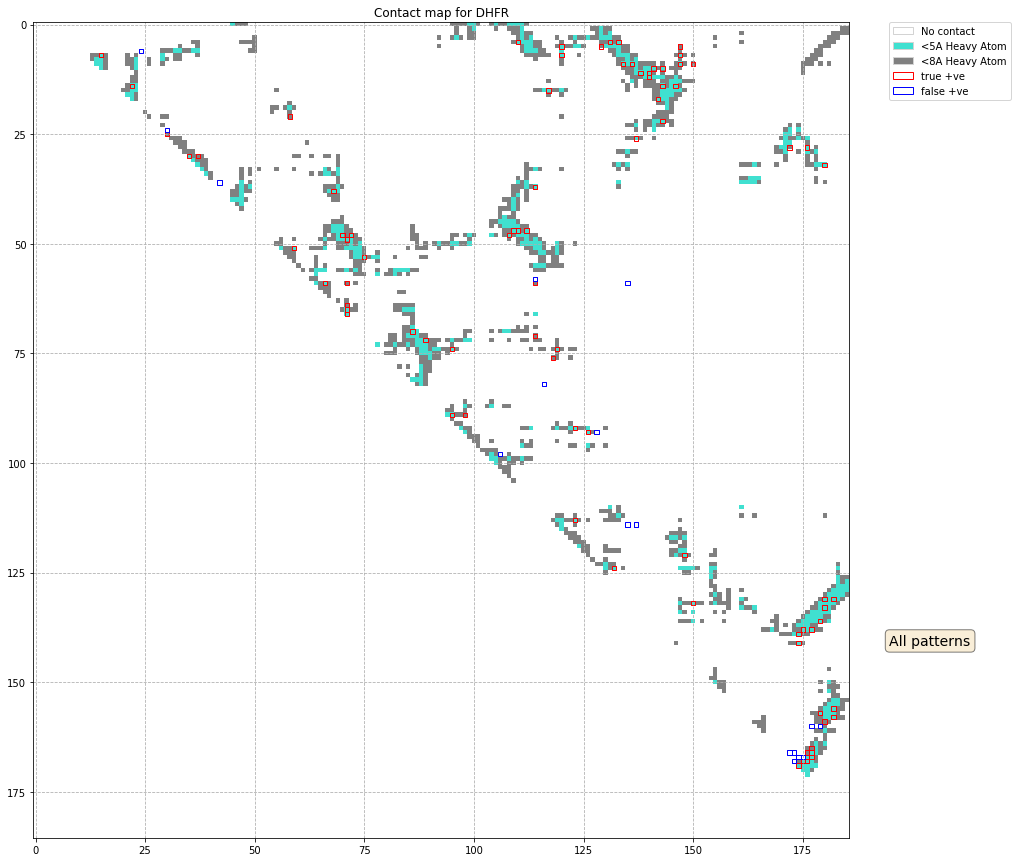

In [16]:
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection


# little rectanges for the true and false positives
matched_rects = []
unmatched_rects = []
for i, j in zip(topn_i, topn_j):
    if contacts[i, j]:
        rects = matched_rects
    else:
        rects = unmatched_rects
    rects.append(mpatches.Rectangle((j - 0.5, i - 0.5), 1, 1))

  
fig, ax = plt.subplots(figsize=(15,15))
plt.title("Contact map for DHFR")

cmap_labels = ["No contact", "<5A Heavy Atom", "<8A Heavy Atom"]
cmap = colors.ListedColormap(['white', 'turquoise', 'grey'])
bounds = [0,0.01,5.01,10]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(contacts, cmap=cmap, norm=norm)

pc_matched = PatchCollection(matched_rects, edgecolors='red', facecolors='none', transOffset=ax.transData)
pc_unmatched = PatchCollection(unmatched_rects, edgecolors='blue', facecolors='none', transOffset=ax.transData)
ax.add_collection(pc_matched)
ax.add_collection(pc_unmatched)

plt.grid(linestyle='--')

patches = [mpatches.Patch(facecolor=cmap.colors[i], label=l, edgecolor='lightgrey') 
           for i, l in enumerate(cmap_labels) ]
patches.append(mpatches.Patch(label='true +ve', edgecolor='red', facecolor='none'))
patches.append(mpatches.Patch(label='false +ve', edgecolor='blue', facecolor='none'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

textstr = "All patterns"
_ = ax.text(1.05, 0.25, textstr, transform = ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


### Plot unique pair counts <a id="uniquepaircounts" />

In [17]:
# Numpy doesn't have a ufunc for addition of byte-strings (type "|S1" is deprecated anyway)
import operator
vadd = np.vectorize(operator.add)

In [18]:
# Pick a weighted random sample of 5000 sequences
np.random.seed(1)
rand_idx = np.random.choice(arr.shape[0], size=5000, p=weights / M_eff)
arr_rand = arr[rand_idx,]

In [19]:
count_unique_pairs_rand_file = os.path.join(datadir, "DHFR.count.unique.pairs.random.npy")
if os.path.isfile(count_unique_pairs_rand_file):
    count_unique_pairs_rand = np.load(count_unique_pairs_rand_file)
    print("Loading count of unique random pairs from :", count_unique_pairs_rand_file)
else:
    for i in range(L):
        for j in range(L):
            if (j < i):
                continue
            concat_arr = vadd(arr_rand[:, i], arr_rand[:, j])
            count_unique_pairs_rand[i,j] = np.unique(concat_arr).size
    count_unique_pairs_rand_file = os.path.join(datadir, "DHFR.count.unique.pairs.random.npy")
    np.save(count_unique_pairs_rand_file, count_unique_pairs_rand)
    print("Finished saving Random Unique Counts file")

Loading count of unique random pairs from : ../data/DHFR.count.unique.pairs.random.npy


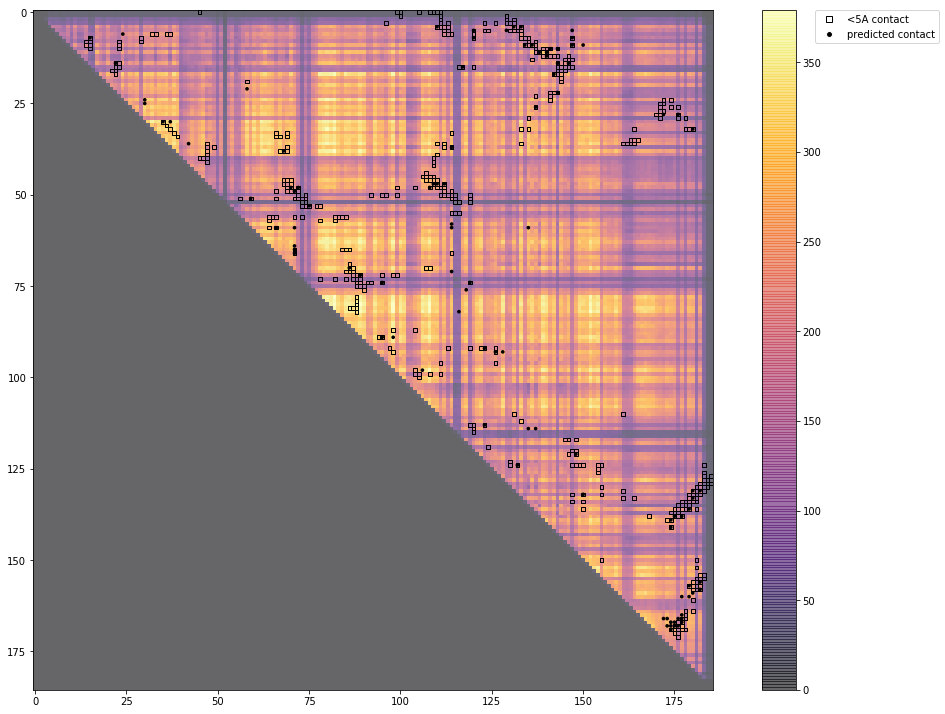

In [20]:

from matplotlib.lines import Line2D      

fig, ax = plt.subplots(figsize=(7*2.5, 5*2.5))

im = ax.imshow(count_unique_pairs_rand, cmap="inferno", alpha=0.6)

contact_rects = [mpatches.Rectangle((j-0.5, i-0.5), 1, 1, label="<5A contact") 
                 for i, j in zip(*np.where(contacts == 5))]
pc_contacts = PatchCollection(contact_rects, edgecolors='black', facecolors='none',
                              transOffset=ax.transData)
ax.add_collection(pc_contacts)
predicted_rects = [mpatches.Circle((i, j), 0.5) for j, i in zip(topn_i, topn_j)]
pc_predicted = PatchCollection(predicted_rects, edgecolors="none", facecolors='black', 
                               transOffset=ax.transData)
ax.add_collection(pc_predicted)

line1 = Line2D(range(1), range(1), color="black", marker='s', linestyle="", label="<5A contact", markerfacecolor="None")
line2 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="black", label="predicted contact")
plt.legend(handles=[line1, line2], bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0. )

fig.colorbar(im)

### Distribution of Unique Pair Counts <a id="paircountdist" />

In [21]:
import pandas as pd
import seaborn as sns

In [22]:
# create upper triangular indices
i, j = zip(*((i, j) for i in range(L) for j in range(L) if i < j))
# create a dataframe of values at each of the upper triangular indices
df = pd.DataFrame({"i":i, "j":j, "unique_count":count_unique_pairs_rand[i, j], 
              "contacts":contacts[i, j]})
df["contacts"] = pd.Categorical(df["contacts"])
df["contacts"] = df.contacts.cat.rename_categories(["No contact", "< 5A", "< 8A" ])

# add predictions
df["predicted"] = 0
for i, j in zip(topn_i, topn_j):
    df.loc[(df["i"] == i) & (df["j"] == j), "predicted"] = 1
df["predicted"] = pd.Categorical(df["predicted"])
df["predicted"] = df.predicted.cat.rename_categories(["no_prediction", "top_n"])

In [23]:
pd.crosstab(df.contacts, df.predicted, margins=True)

predicted,no_prediction,top_n,All
contacts,,,
No contact,15714,17,15731
< 5A,389,66,455
< 8A,1002,17,1019
All,17105,100,17205


In [24]:
ct = pd.crosstab(df.contacts, df.predicted,  values=df.unique_count, aggfunc=np.median, margins=True)
ct.round(1)

predicted,no_prediction,top_n,All
contacts,,,
No contact,194.0,248.0,194.0
< 5A,163.0,217.5,168.0
< 8A,183.0,234.0,184.0
All,193.0,228.0,193.0


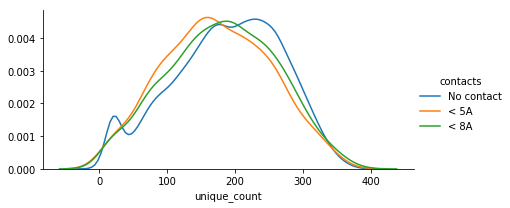

In [25]:
g = sns.FacetGrid(df, hue="contacts", aspect=2)
g.map(sns.kdeplot, "unique_count")
g.add_legend()

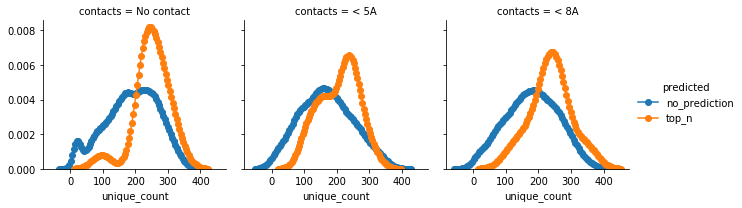

In [26]:
g = sns.FacetGrid(df, col="contacts", hue="predicted")
g.map(sns.kdeplot, "unique_count", marker="o")
g.add_legend()